In [21]:
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

import glob
import random
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

In [22]:
# Define the paths to your directories
day_images_path = '/kaggle/input/daynight-cityview/day/*.jpg'
night_images_path = '/kaggle/input/daynight-cityview/night/*.jpg'

# Collect all image paths
day_image_paths = glob.glob(day_images_path)
night_image_paths = glob.glob(night_images_path)

# Print the number of images in each directory
print('Number of Day images:', len(day_image_paths))
print('Number of Night images:', len(night_image_paths))

Number of Day images: 522
Number of Night images: 227


In [23]:
train_A_paths, test_A_paths = train_test_split(day_image_paths, test_size=0.2, random_state=42)
train_B_paths, test_B_paths = train_test_split(night_image_paths, test_size=0.2, random_state=42)

# Print the number of images in each split
print('Number of training Day images:', len(train_A_paths))
print('Number of testing Day images:', len(test_A_paths))
print('Number of training Night images:', len(train_B_paths))
print('Number of testing Night images:', len(test_B_paths))

Number of training Day images: 417
Number of testing Day images: 105
Number of training Night images: 181
Number of testing Night images: 46


In [24]:
# HYPERPARAMETERS 
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(
    epoch=0,
    n_epochs=200,    
    dataset_train_mode="train",
    dataset_test_mode="test", 
    batch_size=4,        
    lr=.0002,
    decay_start_epoch=100,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    n_critic=5,
    sample_interval=100,
    num_residual_blocks=19,
    lambda_cyc=10.0,
    lambda_id=5.0)

In [25]:
root_path = '/kaggle/input/daynight-cityview'

In [26]:
def convert_to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ImageDataset(Dataset):
    def __init__(self, day_images_path, night_images_path, transforms_=None, unaligned=False):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned        

        self.files_A = sorted(glob.glob(day_images_path))
        self.files_B = sorted(glob.glob(night_images_path))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        # a % b => a is divided by b, and the remainder of that division is returned.

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = convert_to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = convert_to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        
        # Finally ruturn a dict
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [27]:
# Methods for Image Visualization

def show_img(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size * 2, size * 2))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis('off')
  plt.show()

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg

def plot_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

## Get Train and Validation Dataloader

In [28]:
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

train_dataset = ImageDataset(day_images_path, night_images_path, transforms_=transforms_, unaligned=False)
val_dataset = ImageDataset(day_images_path, night_images_path, transforms_=transforms_, unaligned=False)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

for i, batch in enumerate(train_dataloader):
    print(batch["A"].shape, batch["B"].shape)
    break  # Just to check one batch

torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 128, 128])


## Visualize some sample images

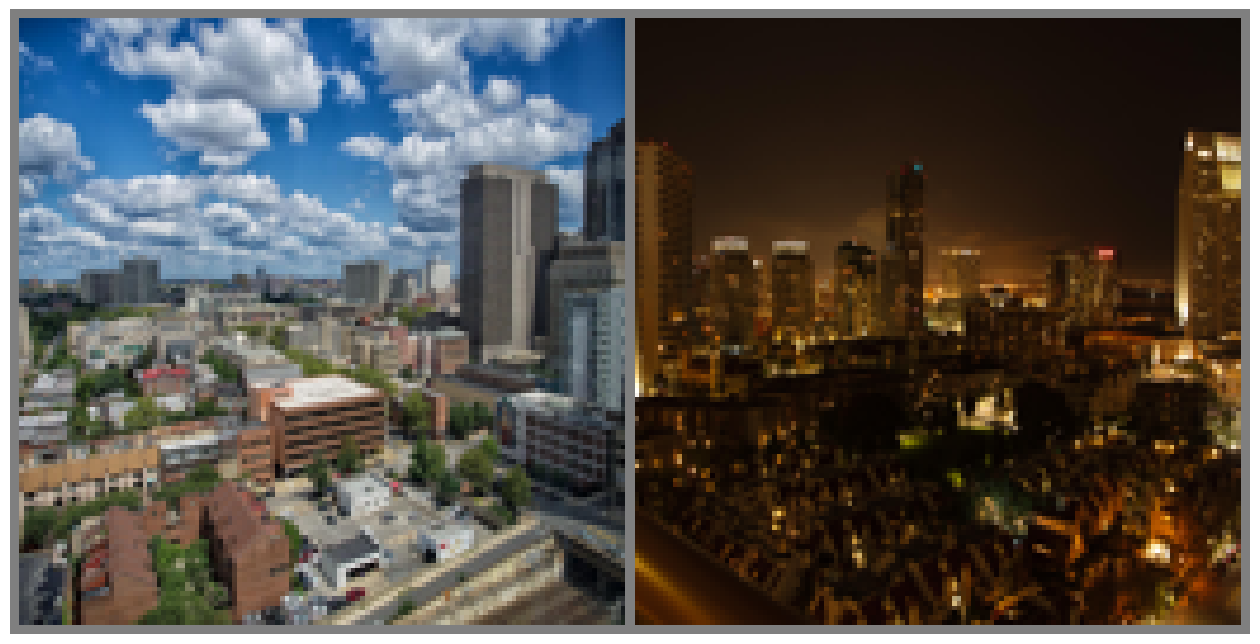

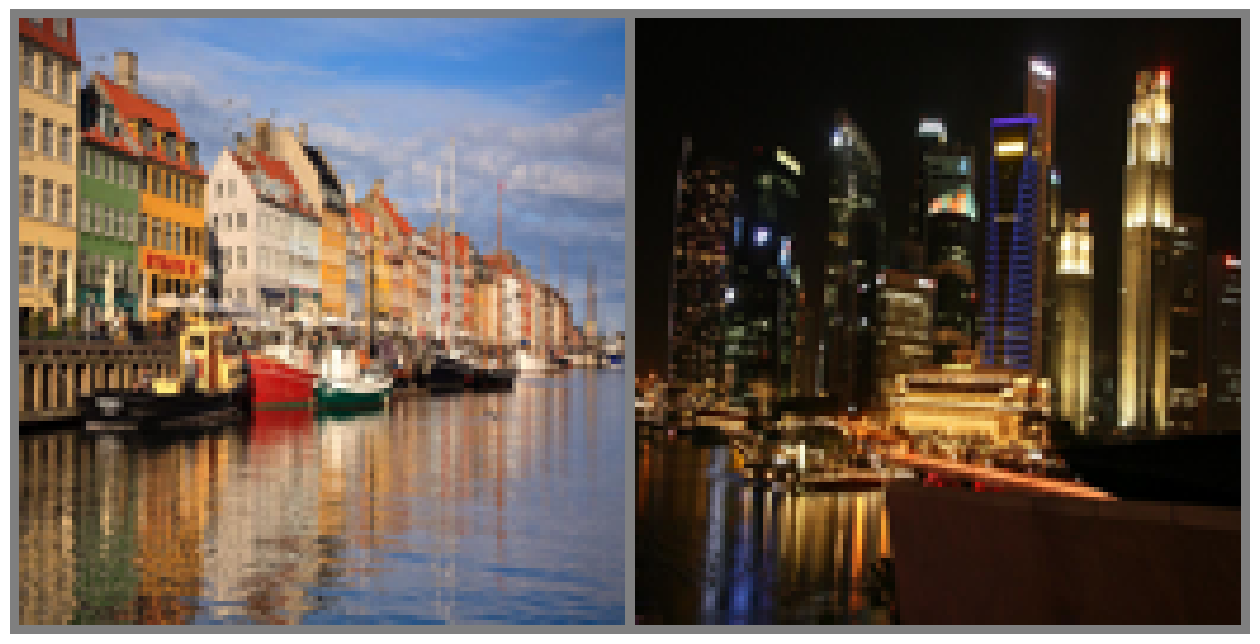

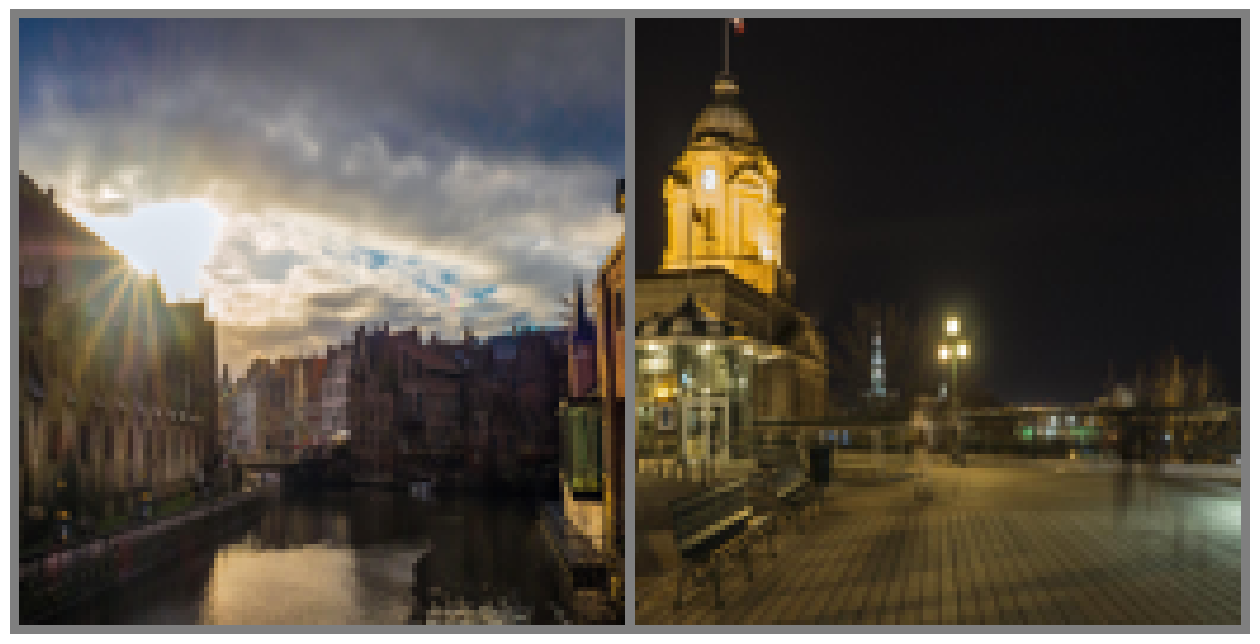

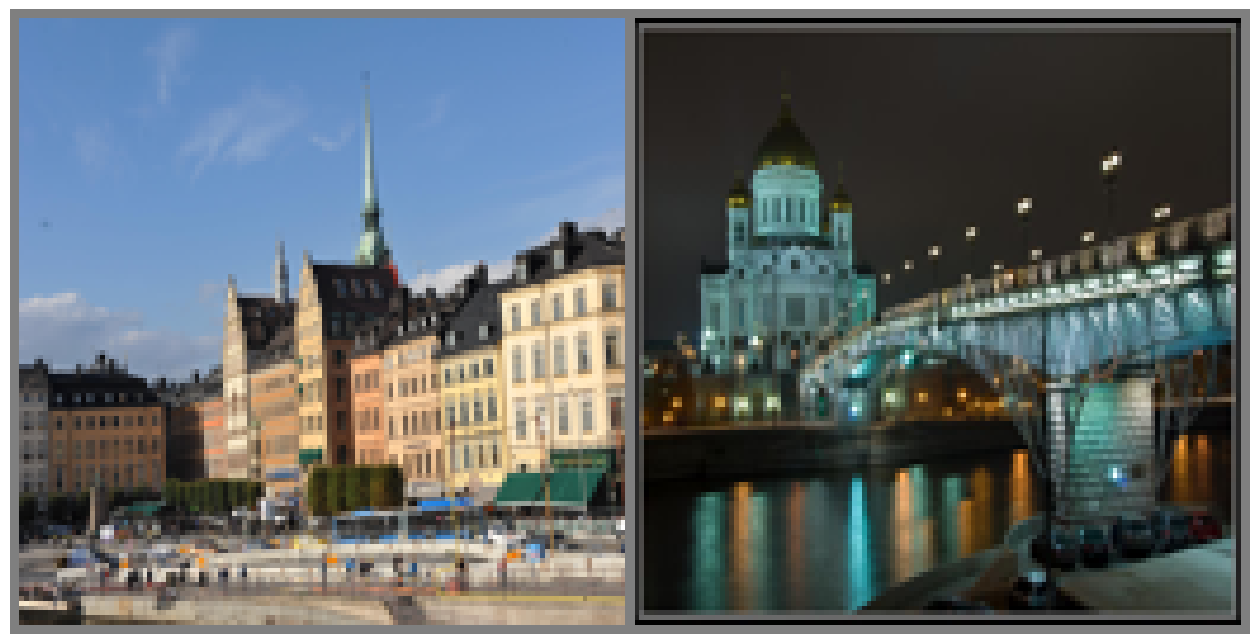

In [29]:
pic_size = 8 

dataiter = iter(train_dataloader)
images = next(dataiter)

for i in range(len(images["A"])):
  show_img(make_grid([images["A"][i],images["B"][i]]), size=pic_size)

## Replay Buffer 

In [30]:
# ReplayBuffer
class ReplayBuffer:
    # We keep an image buffer that stores
    # the 50 previously created images.
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                # Returns newly added image with a probability of 0.5.
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[
                        i
                    ] = element  # replaces the older image with the newly generated image.
                else:
                    # Otherwise, it sends an older generated image and
                    to_return.append(element)
        return Variable(torch.cat(to_return))


In [31]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        # Below line checks whether the current epoch has exceeded the decay epoch(which is 100)
        # e.g. if current epoch is 80 then max (0, 80 - 100) will be 0. 
        # i.e. then entire numerator will be 0 - so 1 - 0 is 1
        # i.e. the original LR remains as it is.
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

### Initialize convolution layer weights to N(0,0.02)

In [32]:
def initialize_conv_weights_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# GENERATOR & DISCRIMINATOR

In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Reflection padding is used because it gives better image quality at edges.
            nn.Conv2d(in_channel, in_channel, 3), # Paper says - same number of filters on both layer.
            nn.InstanceNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel),
        )

    def forward(self, x):
        return x + self.block(x)

In [34]:
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_channels = 64
        # I define a variable 'model' which I will continue to update
        # throughout the 3 blocks of Residual -> Downsampling -> Upsampling
        # First c7s1-64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_channels, 7),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        in_channels = out_channels

        # Downsampling
        # d128 => d256
        for _ in range(2):
            out_channels *= 2
            model += [
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        """ Residual blocks - Per Paper
        R256,R256,R256,R256,R256,R256,R256,R256,R256
        """
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]

        # Upsampling
        # u128 => u64
        for _ in range(2):
            out_channels //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        # Output layer
        model += [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(out_channels, channels, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [35]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_channels, out_channels, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # C64 -> C128 -> C256 -> C512
        self.model = nn.Sequential(
            *discriminator_block(channels, out_channels=64, normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=1)
        )
        # With nn.ZeroPad2d((1, 0, 1, 0)) I am Zero padding
        # on top and left to keep the output height and width same with the 4×4 kernel

    def forward(self, img):
        return self.model(img)

In [36]:
# SETUP, LOSS, INITIALIZE MODELS and BUFFERS

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

# Loss functions
# Creating criterion object that will measure the error between the prediction and the target.
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (hp.channels, hp.img_size, hp.img_size)

# Initialize generator and discriminator
Gen_AB = GeneratorResNet(input_shape, hp.num_residual_blocks)
Gen_BA = GeneratorResNet(input_shape, hp.num_residual_blocks)
Disc_A = Discriminator(input_shape)
Disc_B = Discriminator(input_shape)

if cuda:
    Gen_AB = Gen_AB.cuda()
    Gen_BA = Gen_BA.cuda()
    Disc_A = Disc_A.cuda()
    Disc_B = Disc_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

# Initialize weights
Gen_AB.apply(initialize_conv_weights_normal)
Gen_BA.apply(initialize_conv_weights_normal)
Disc_A.apply(initialize_conv_weights_normal)
Disc_B.apply(initialize_conv_weights_normal)

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

Using CUDA


In [37]:
# SAMPLING IMAGES
def save_img_samples(batches_done):
    """Saves a generated sample from the test set"""
    print('Epochs_done ', batches_done)
    imgs = next(iter(val_dataloader))
    Gen_AB.eval()
    Gen_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = Gen_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = Gen_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=16, normalize=True)
    real_B = make_grid(real_B, nrow=16, normalize=True)
    fake_A = make_grid(fake_A, nrow=16, normalize=True)
    fake_B = make_grid(fake_B, nrow=16, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)    
    #path =  root_path + "/%s.png" % (batches_done)    # Path when running in Google Colab
    path =  '/kaggle/working' + "/%s.png" % (batches_done)    # Path when running inside Kaggle
    save_image(image_grid, path, normalize=False)    
    return path  

## Optimizers

In [38]:
optimizer_G = torch.optim.Adam(
    itertools.chain(Gen_AB.parameters(), Gen_BA.parameters()), lr=hp.lr, betas=(hp.b1, hp.b2)
)
optimizer_Disc_A = torch.optim.Adam(Disc_A.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

optimizer_Disc_B = torch.optim.Adam(Disc_B.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_A, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_B, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)


Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [39]:
from tqdm import tqdm
import os

def train(
    Gen_BA,
    Gen_AB,
    Disc_A,
    Disc_B,
    train_dataloader,
    n_epochs,
    criterion_identity,
    criterion_cycle,
    lambda_cyc,
    criterion_GAN,
    optimizer_G,
    fake_A_buffer,
    fake_B_buffer,
    clear_output,
    optimizer_Disc_A,
    optimizer_Disc_B,
    Tensor,
    sample_interval,
    lambda_id,
    save_dir="saved_models"
):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Initialize lists to store losses
    loss_G_list = []
    loss_D_list = []
    loss_GAN_list = []
    loss_cycle_list = []
    loss_identity_list = []

    # TRAINING
    prev_time = time.time()
    for epoch in tqdm(range(hp.epoch, n_epochs), desc="Epochs"):
        total_loss_G = 0
        total_loss_D = 0
        total_loss_GAN = 0
        total_loss_cycle = 0
        total_loss_identity = 0

        for i, batch in enumerate(train_dataloader):
            # Set model input
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))

            # Adversarial ground truths
            valid = Variable(
                Tensor(np.ones((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )
            fake = Variable(
                Tensor(np.zeros((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )

            #########################
            #  Train Generators
            #########################

            Gen_AB.train()  # Gen_AB(real_A) will take real_A and produce fake_B
            Gen_BA.train()  # Gen_BA(real_B) will take real_B and produce fake_A

            optimizer_G.zero_grad()

            # Identity loss
            loss_id_A = criterion_identity(Gen_BA(real_A), real_A)
            loss_id_B = criterion_identity(Gen_AB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN losses for GAN_AB
            fake_B = Gen_AB(real_A)
            loss_GAN_AB = criterion_GAN(Disc_B(fake_B), valid)

            # GAN losses for GAN_BA
            fake_A = Gen_BA(real_B)
            loss_GAN_BA = criterion_GAN(Disc_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle Consistency losses
            reconstructed_A = Gen_BA(fake_B)
            loss_cycle_A = criterion_cycle(reconstructed_A, real_A)
            reconstructed_B = Gen_AB(fake_A)
            loss_cycle_B = criterion_cycle(reconstructed_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total Generators Loss and Back propagation
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
            loss_G.backward()
            optimizer_G.step()

            #########################
            #  Train Discriminator A
            #########################

            optimizer_Disc_A.zero_grad()

            # Real loss
            loss_real = criterion_GAN(Disc_A(real_A), valid)
            # Fake loss (on batch of previously generated samples)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(Disc_A(fake_A_.detach()), fake)
            loss_Disc_A = (loss_real + loss_fake) / 2
            loss_Disc_A.backward()
            optimizer_Disc_A.step()

            #########################
            #  Train Discriminator B
            #########################

            optimizer_Disc_B.zero_grad()

            # Real loss
            loss_real = criterion_GAN(Disc_B(real_B), valid)
            # Fake loss (on batch of previously generated samples)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(Disc_B(fake_B_.detach()), fake)
            loss_Disc_B = (loss_real + loss_fake) / 2
            loss_Disc_B.backward()
            optimizer_Disc_B.step()

            loss_D = (loss_Disc_A + loss_Disc_B) / 2

            ##################
            #  Log Progress
            ##################

            total_loss_G += loss_G.item()
            total_loss_D += loss_D.item()
            total_loss_GAN += loss_GAN.item()
            total_loss_cycle += loss_cycle.item()
            total_loss_identity += loss_identity.item()

        # Calculate average losses for the epoch
        avg_loss_G = total_loss_G / len(train_dataloader)
        avg_loss_D = total_loss_D / len(train_dataloader)
        avg_loss_GAN = total_loss_GAN / len(train_dataloader)
        avg_loss_cycle = total_loss_cycle / len(train_dataloader)
        avg_loss_identity = total_loss_identity / len(train_dataloader)

        # Store losses
        loss_G_list.append(avg_loss_G)
        loss_D_list.append(avg_loss_D)
        loss_GAN_list.append(avg_loss_GAN)
        loss_cycle_list.append(avg_loss_cycle)
        loss_identity_list.append(avg_loss_identity)

        # Print losses for the epoch
        print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f]"
            % (
                epoch,
                n_epochs,
                avg_loss_D,
                avg_loss_G,
                avg_loss_GAN,
                avg_loss_cycle,
                avg_loss_identity,
            )
        )

        # Save weights every 50 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(Gen_AB.state_dict(), f"{save_dir}/Gen_AB_{epoch+1}.pth")
            torch.save(Gen_BA.state_dict(), f"{save_dir}/Gen_BA_{epoch+1}.pth")
            torch.save(Disc_A.state_dict(), f"{save_dir}/Disc_A_{epoch+1}.pth")
            torch.save(Disc_B.state_dict(), f"{save_dir}/Disc_B_{epoch+1}.pth")

        # Save and display images after each epoch
        #clear_output()
        plot_output(save_img_samples(epoch + 1), 30, 40)

    # Plot losses after training
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(loss_G_list, label="G")
    plt.plot(loss_D_list, label="D")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title("Adversarial, Cycle, and Identity Loss During Training")
    plt.plot(loss_GAN_list, label="GAN")
    plt.plot(loss_cycle_list, label="Cycle")
    plt.plot(loss_identity_list, label="Identity")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


Epochs_done  2


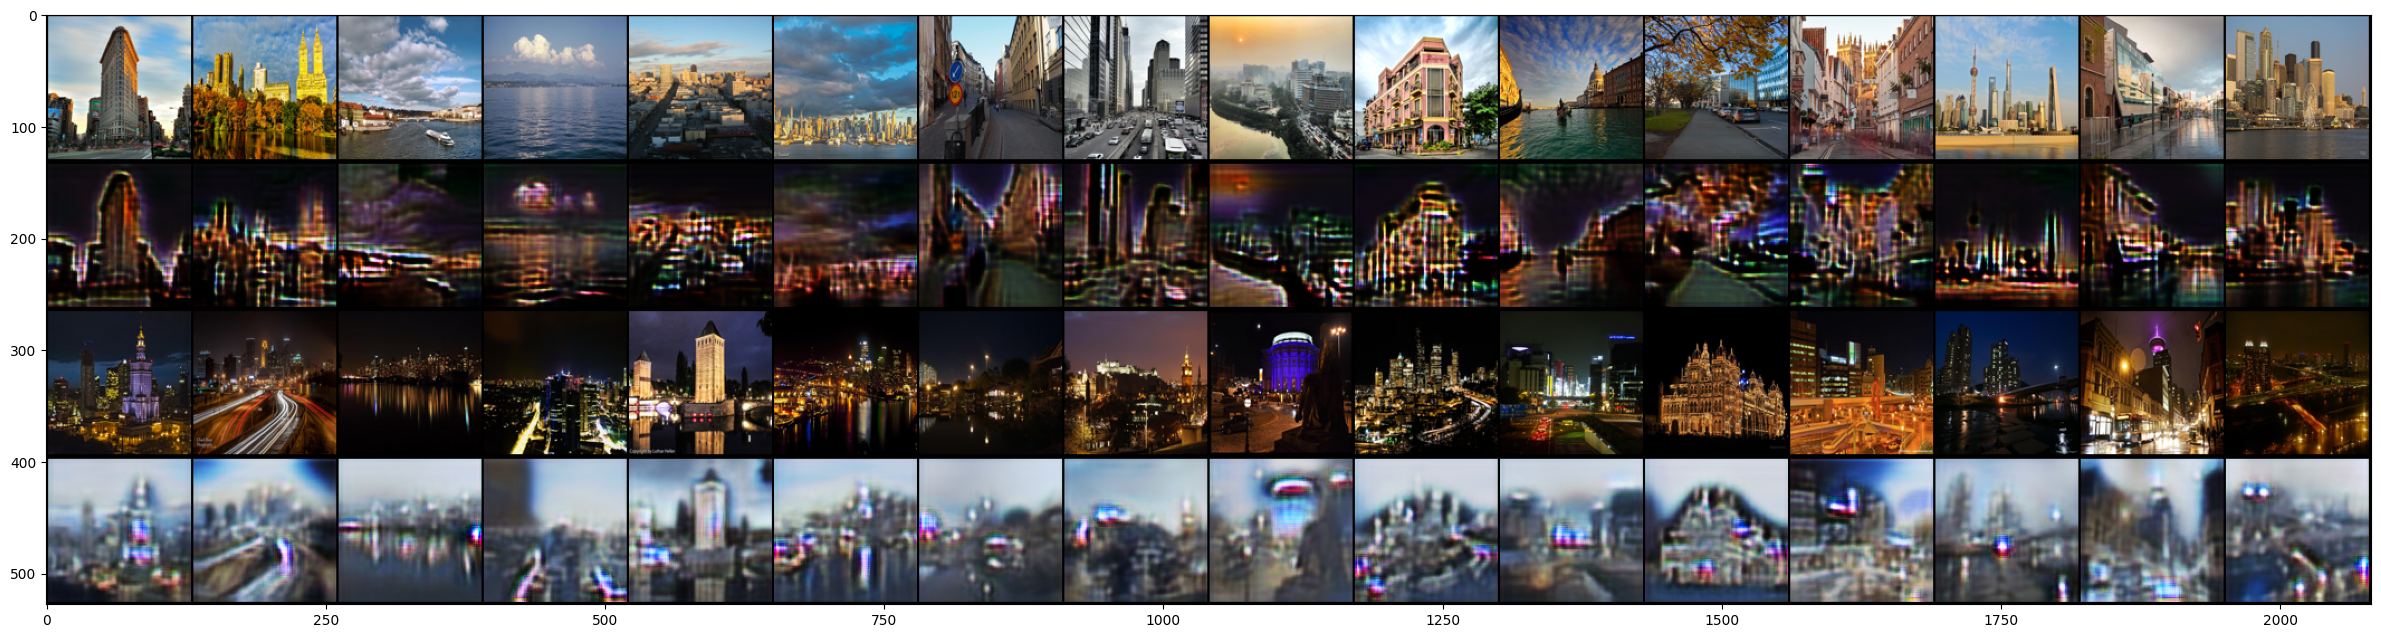

Epochs: 100%|██████████| 2/2 [03:25<00:00, 102.50s/it]


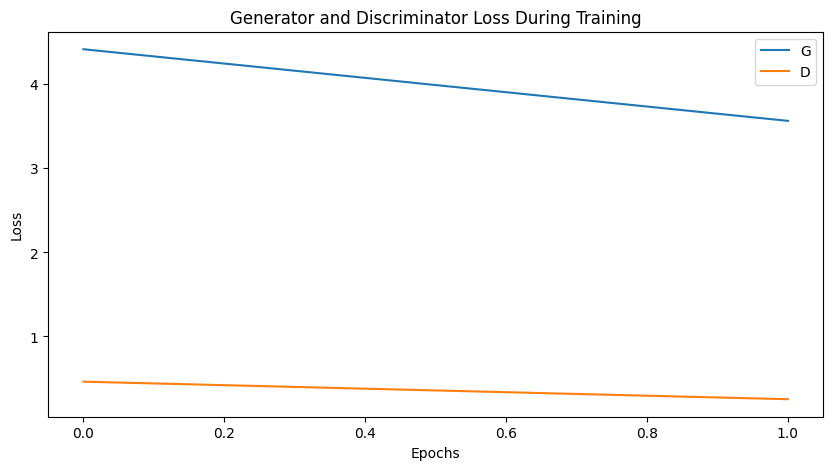

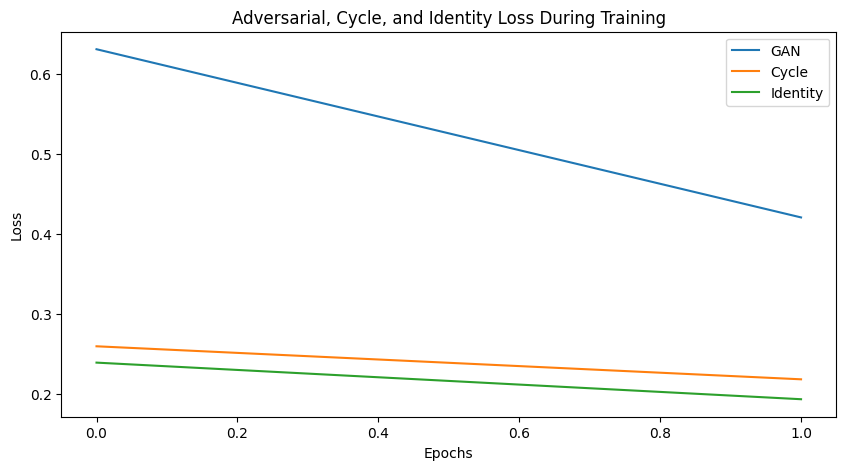

In [40]:
train(
    Gen_BA = Gen_BA,
    Gen_AB = Gen_AB,
    Disc_A = Disc_A,
    Disc_B = Disc_B,
    train_dataloader = train_dataloader,
    n_epochs = hp.n_epochs,
    criterion_identity = criterion_identity,
    criterion_cycle = criterion_cycle,
    lambda_cyc = hp.lambda_cyc,
    criterion_GAN = criterion_GAN,
    optimizer_G = optimizer_G,
    fake_A_buffer = fake_A_buffer,
    fake_B_buffer = fake_B_buffer,
    clear_output = clear_output,
    optimizer_Disc_A = optimizer_Disc_A,
    optimizer_Disc_B = optimizer_Disc_B,
    Tensor = Tensor,
    sample_interval = hp.sample_interval,
    lambda_id = hp.lambda_id,
)

In [71]:
import torch
from torchvision.utils import save_image, make_grid
from torchvision.transforms import Resize, ToPILImage, ToTensor
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.image as mpimg

def show_img(img, size=10):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(size, size))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def plot_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x, y))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def save_img_samples(batches_done, val_dataloader, Gen_AB, Gen_BA, Tensor, save_dir="/kaggle/working"):
    """Saves a generated sample from the test set"""
    print('Batches_done ', batches_done)
    imgs = next(iter(val_dataloader))
    Gen_AB.eval()
    Gen_BA.eval()
    real_A = imgs["A"].type(Tensor)
    fake_B = Gen_AB(real_A)
    real_B = imgs["B"].type(Tensor)
    fake_A = Gen_BA(real_B)
    
    # Normalize images for display
    real_A = make_grid(real_A, nrow=8, normalize=True)
    fake_B = make_grid(fake_B, nrow=8, normalize=True)
    real_B = make_grid(real_B, nrow=8, normalize=True)
    fake_A = make_grid(fake_A, nrow=8, normalize=True)

    # Arrange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    path = f"{save_dir}/{batches_done}.png"
    save_image(image_grid, path, normalize=False)
    return path

def test(Gen_BA, Gen_AB, test_dataloader, Tensor, save_dir="test_output"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    Gen_BA.eval()
    Gen_AB.eval()
    
    # Test only one batch
    path = save_img_samples(0, test_dataloader, Gen_AB, Gen_BA, Tensor, save_dir)
    plot_output(path, 30, 20)

Epochs_done  0


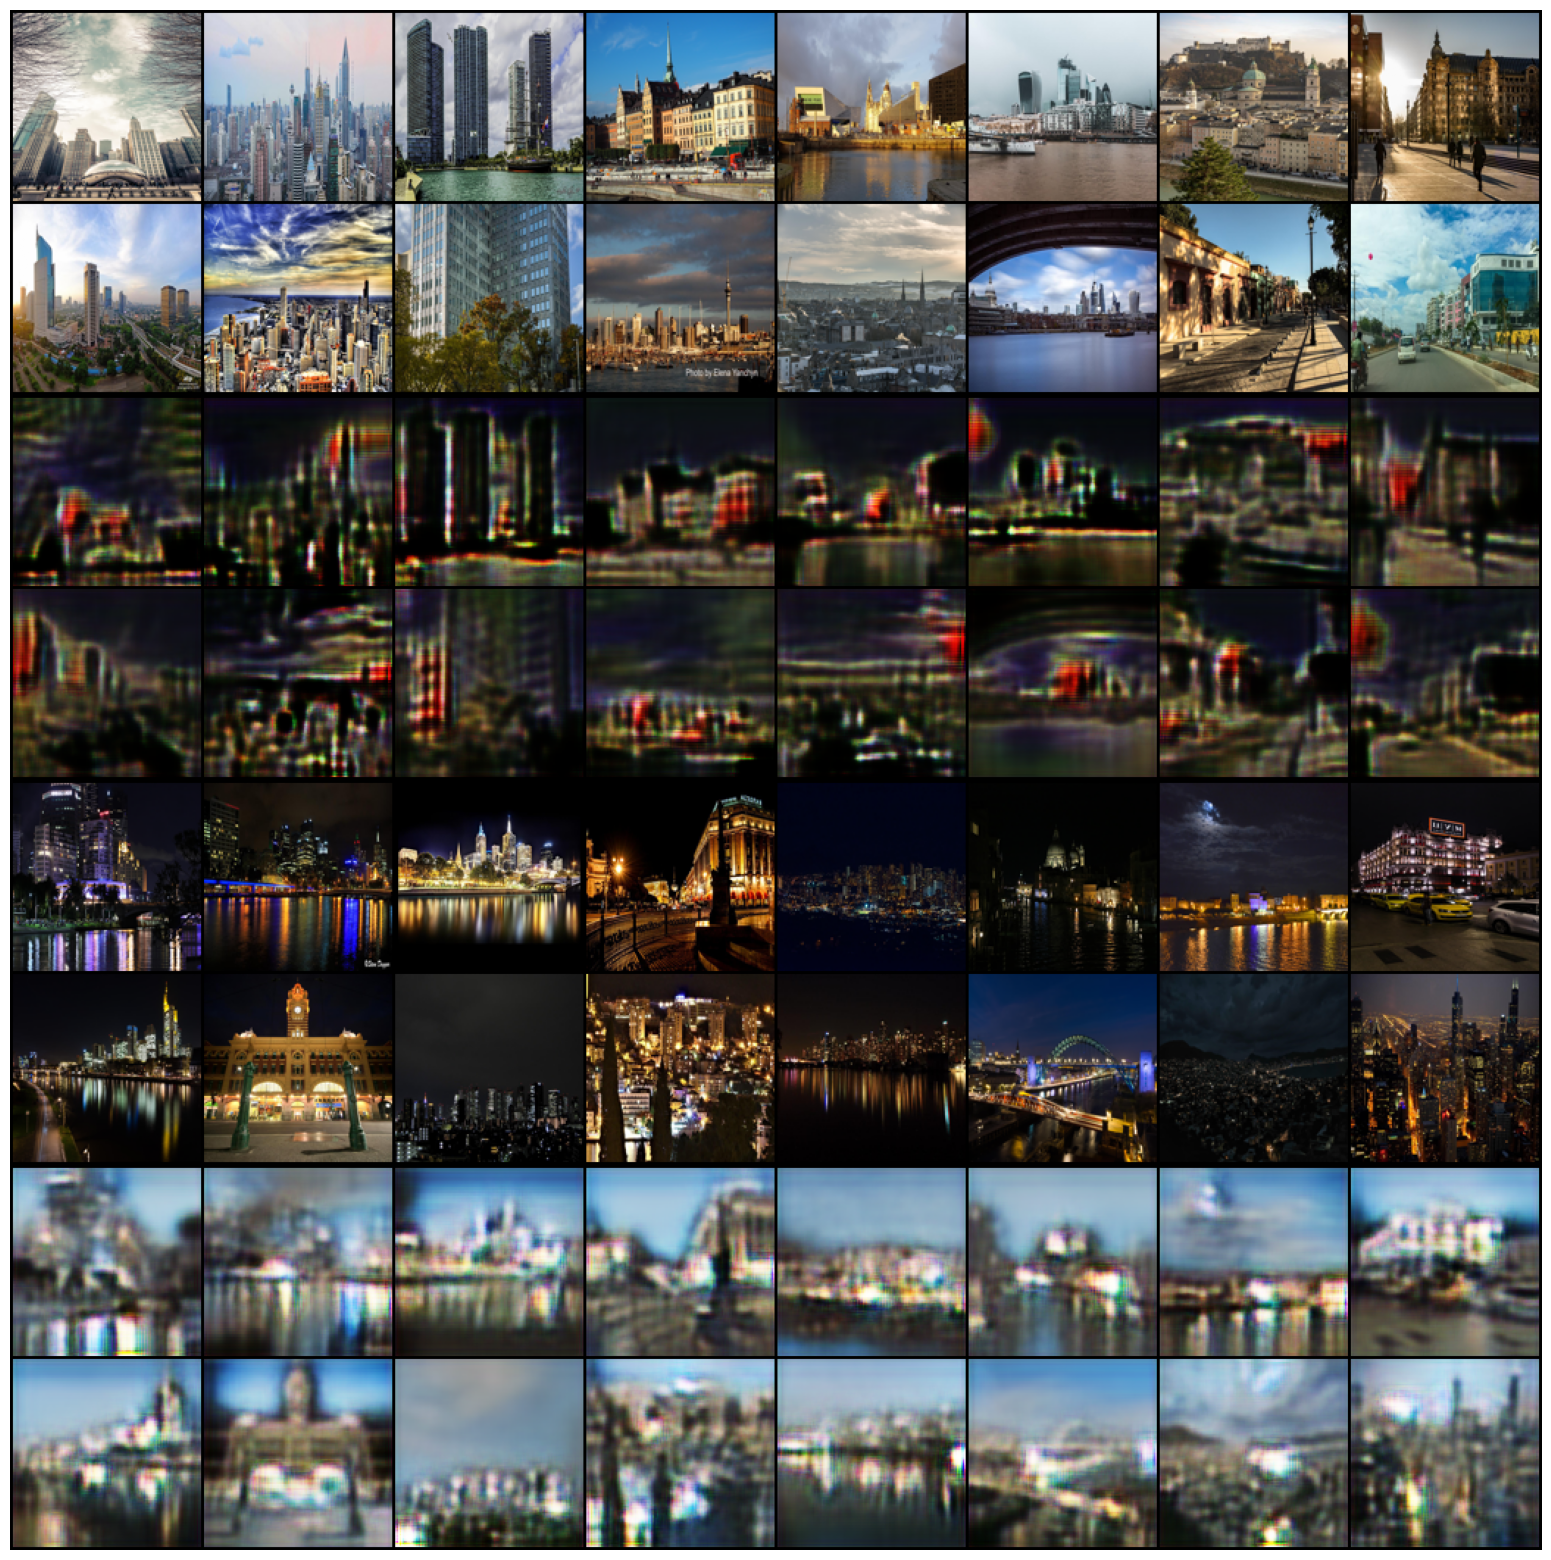

In [72]:
# Load your trained models
Gen_BA = Gen_BA
Gen_AB = Gen_AB
Gen_BA.load_state_dict(torch.load('/kaggle/working/saved_models/Gen_BA_1.pth'))
Gen_AB.load_state_dict(torch.load('/kaggle/working/saved_models/Gen_AB_1.pth'))

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Gen_BA.to(device)
Gen_AB.to(device)

# Tensor type
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# Call the test function
test(Gen_BA, Gen_AB, val_dataloader, Tensor, save_dir="test_output")